# Importando Bibliotecas

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
plt.figure(figsize=(20, 12))

<Figure size 2000x1200 with 0 Axes>

<Figure size 2000x1200 with 0 Axes>

# Carregando Dataset

In [56]:
df = pd.read_csv("Data/VendasSupermercadosCDI.csv", sep=";")
df.head()

,Date,VendasSupermercados,CDI
0,2010-01-01,76.39,0.66
1,2010-02-01,73.95,0.59
2,2010-03-01,81.69,0.76
3,2010-04-01,77.91,0.66
4,2010-05-01,78.66,0.75


O dataset possui três colunas 
- **Date:** Representa da data das vendas no supermercado
- **VendasSupermercados:** Vendas do supermercado naquele dia
- **CDI:** Valor do CDI (Certificado de Depósito Interbancário) naquele dia

# Análise Exploratória de Dados

In [57]:
df.columns

Index(['Date', 'VendasSupermercados', 'CDI'], dtype='object')

In [58]:
# Analisando as dimensões do dataset
df.shape

(164, 3)

O dataset possui poucas linhas e colunas, então buscaremos criar mais variáveis para melhorar o modelo final

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 164 non-null    object 
 1   VendasSupermercados  164 non-null    float64
 2   CDI                  164 non-null    float64
dtypes: float64(2), object(1)
memory usage: 4.0+ KB


As features não possuem valores ausentes. As **VendasSupermercados** e **CDI** estão num formato correto, porém a **Date** precisar ser transformado para datetime

In [60]:
def convert_date_column(df, column_name):
    df[column_name] = pd.to_datetime(df[column_name])

convert_date_column(df, 'Date')
df.Date.info()

<class 'pandas.core.series.Series'>
RangeIndex: 164 entries, 0 to 163
Series name: Date
Non-Null Count  Dtype         
--------------  -----         
164 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.4 KB


In [61]:
df.describe()

,Date,VendasSupermercados,CDI
count,164,164.000000,164.000000
mean,2016-10-15 19:19:01.463414528,93.174329,0.738537
min,2010-01-01 00:00:00,73.950000,0.130000
25%,2013-05-24 06:00:00,88.070000,0.537500
50%,2016-10-16 12:00:00,91.700000,0.785000
75%,2020-03-08 18:00:00,97.612500,0.952500
max,2023-08-01 00:00:00,122.750000,1.210000
std,NaN,9.001255,0.281626


Vemos que a média e mediana das **VendasSupermercados** estão próximas, isso pode indicar uma distribuição mais simétrica dos dados e provavelmente pouca presença de outliers. Além disso, o desvio padrão do **CDI** está em quase 40% da média do **CDI** o que indica uma variabilidade considerável

In [62]:
df.nunique(axis=0)

Date                   164
VendasSupermercados    152
CDI                     75
dtype: int64

Percebemos que não há datas repitidas, porém alguns dias com o mesmo número de vendas da mesma forma do CDI

In [63]:
df.VendasSupermercados.value_counts()

VendasSupermercados
87.41     2
97.68     2
94.48     2
89.43     2
84.39     2
         ..
92.38     1
89.01     1
116.78    1
96.75     1
104.75    1
Name: count, Length: 152, dtype: int64

In [64]:
df.CDI.value_counts()

CDI
0.54    8
1.11    6
0.86    6
0.84    5
1.07    5
       ..
1.00    1
1.21    1
1.08    1
0.50    1
1.14    1
Name: count, Length: 75, dtype: int64

isso confirma o que falamos acima e vemos quais os valores com repeticões e quais os mais repitidos

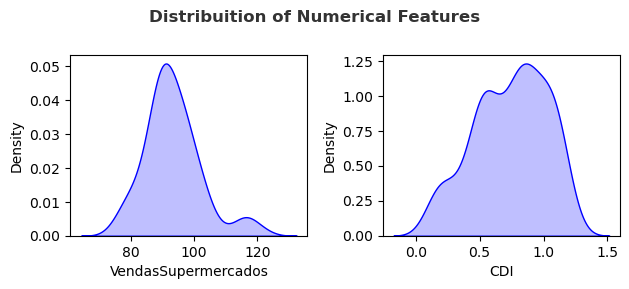

In [88]:
numerical_features = ['VendasSupermercados', 'CDI']

plt.suptitle('Distribuition of Numerical Features', fontsize=12, fontweight='bold', alpha=0.8, y=1.)

for i in range(len(numerical_features)):
    plt.subplot(2, 2, i+1)
    sns.kdeplot(x=df[numerical_features[i]], shade=True, color='b')
    plt.xlabel(numerical_features[i])
    plt.tight_layout()

Vemos que as ditribuição de **VendasSupermercados** possui dois dois picos um menor e um maior que mostra que não segue uma distribuição normal bem definida, já a distribuição do **CDI** é bastante distorcida de uma districuição mais convencional o que deve dificultar a modelagem